In [ ]:
## importing libraries

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce

# Load & scale data
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Feature selection & modeling
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Model selection & tuning
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform

# Evaluation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# setup

from google.colab import drive
drive.mount('/content/drive')

# Set project directory
folder_path = "/content/drive/MyDrive/Colab Notebooks/ML project"

# CSVs
stats = pd.read_csv(f"{folder_path}/Seasons_Stats_2000_onward.csv")
salaries_2000_2019 = pd.read_csv(f"{folder_path}/NBA_Full_Salaries_2000-2019.csv")
salaries_2020_2025 = pd.read_csv(f"{folder_path}/Nba Player Salaries.csv")
player_info = pd.read_csv(f"{folder_path}/player_data.csv")
draft = pd.read_csv(f"{folder_path}/nbaplayersdraft.csv")

mvp = pd.read_csv(f"{folder_path}/sportsref_mvp.csv", skiprows=1)
dpoy = pd.read_csv(f"{folder_path}/sportsred_dpoy.csv", skiprows=1)
roy = pd.read_csv(f"{folder_path}/sportsref_roty.csv", skiprows=1)
mip = pd.read_csv(f"{folder_path}/sportsref_mip.csv", skiprows=1)
all_nba = pd.read_csv(f"{folder_path}/sportsref_allnba.csv")
all_def = pd.read_csv(f"{folder_path}/sportsref_alldefense.csv")
all_star = pd.read_csv(f"{folder_path}/nbaallstargames.csv")

team_records = pd.read_csv(f"{folder_path}/Team_Records.csv")


Mounted at /content/drive


In [ ]:
## Filtering to only year 2000 and after

# Handling years that are 2000-01 and just "2001"
def extract_nba_season_year(season_str):
    try:
        season_str = str(season_str)
        if '-' not in season_str:
            return int(season_str)
        parts = season_str.split('-')
        end_suffix = int(parts[1])
        return 2000 + end_suffix if end_suffix < 50 else 1900 + end_suffix
    except:
        return np.nan

# filtering function
def filter_by_year(df, col_name, min_year=2000):
    if col_name not in df.columns:
        raise ValueError(f"Column '{col_name}' not found in DataFrame.")
    df[col_name] = df[col_name].apply(extract_nba_season_year)
    return df[df[col_name] >= min_year].copy()

# standardize column name
stats.rename(columns={'Year': 'Season'}, inplace=True)
salaries_2000_2019.rename(columns={'Year': 'Season'}, inplace=True)
all_star.rename(columns={'Year': 'Season'}, inplace=True)

# Apply filtering
salaries_2000_2019 = filter_by_year(salaries_2000_2019, "Season")
player_info = filter_by_year(player_info, "year_start")
draft = filter_by_year(draft, "year")
all_star = filter_by_year(all_star, "Season")
all_nba = filter_by_year(all_nba, "Season")
all_def = filter_by_year(all_def, "Season")
team_records = filter_by_year(team_records, "Season")
mvp = filter_by_year(mvp, "Season")
dpoy = filter_by_year(dpoy, "Season")
roy = filter_by_year(roy, "Season")
mip = filter_by_year(mip, "Season")


In [ ]:
## Cleaning and Merging Award Data

# Converts team string like "1st Team" to numeric level
def extract_team_num(val):
    if pd.isnull(val): return 0
    val = str(val).lower()
    if '1st' in val: return 1
    if '2nd' in val: return 2
    if '3rd' in val: return 3
    return 0

# Normalize individual award datasets
award_dfs = [(mvp, 'MVP'), (dpoy, 'DPOY'), (roy, 'ROY'), (mip, 'MIP')]
normalized_awards = []

for df, label in award_dfs:
    df['Season'] = df['Season'].apply(extract_nba_season_year)
    df[label] = 1
    normalized_awards.append(df[['Player', 'Season', label]])

# Reshape All-NBA data to long format
unnamed_cols_nba = [col for col in all_nba.columns if col.startswith('Unnamed')]
all_nba_melted = all_nba.melt(
    id_vars=['Season', 'Tm'],
    value_vars=unnamed_cols_nba,
    var_name='Slot',
    value_name='PlayerName'
).dropna(subset=['PlayerName'])

all_nba_melted['Season'] = all_nba_melted['Season'].apply(extract_nba_season_year)
all_nba_melted['ALL_NBA_TEAM'] = all_nba_melted['Tm'].apply(extract_team_num)
all_nba_melted.rename(columns={'PlayerName': 'Player'}, inplace=True)

# Remove position suffix from names
all_nba_melted['Player'] = all_nba_melted['Player'].str.extract(r'^(.*?)(?:\s+[A-Z])?$')[0].str.strip()
all_nba = all_nba_melted[['Player', 'Season', 'ALL_NBA_TEAM']]

# Reshape All-Defensive data
unnamed_cols_def = [col for col in all_def.columns if col.startswith('Unnamed')]
all_def_melted = all_def.melt(
    id_vars=['Season', 'Tm'],
    value_vars=unnamed_cols_def,
    var_name='Slot',
    value_name='PlayerName'
).dropna(subset=['PlayerName'])

all_def_melted['Season'] = all_def_melted['Season'].apply(extract_nba_season_year)
all_def_melted['ALL_DEF_TEAM'] = all_def_melted['Tm'].apply(extract_team_num)
all_def_melted.rename(columns={'PlayerName': 'Player'}, inplace=True)
all_def = all_def_melted[['Player', 'Season', 'ALL_DEF_TEAM']]

# Normalize All-Star data
all_star.rename(columns={'Year': 'Season'}, inplace=True)
all_star['ALL_STAR_MVP'] = all_star['MVP'].apply(lambda x: 1 if str(x).strip().upper() == 'Y' else 0)
role_map = {'DNP': 1, 'Reserve': 2, 'Starter': 3}
all_star['ALL_STAR_ROLE'] = all_star['Role'].map(role_map).fillna(0).astype(int)
all_star = all_star[['Player', 'Season', 'ALL_STAR_ROLE', 'ALL_STAR_MVP']]

# Merge all award tables
award_tables = normalized_awards + [all_nba, all_def, all_star]
awards = reduce(lambda left, right: pd.merge(left, right, on=['Player', 'Season'], how='outer'), award_tables)

# Fill missing values with 0
awards.fillna({
    'MVP': 0, 'DPOY': 0, 'ROY': 0, 'MIP': 0,
    'ALL_NBA_TEAM': 0, 'ALL_DEF_TEAM': 0,
    'ALL_STAR_MVP': 0, 'ALL_STAR_ROLE': 0
}, inplace=True)

# Standardize column names
awards.columns = awards.columns.str.lower().str.strip().str.replace('%', 'pct').str.replace('/', '_')

# Preview
awards.head()


,player,season,mvp,dpoy,roy,mip,all_nba_team,all_def_team,all_star_role,all_star_mvp
0,Aaron Brooks,2010,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Al Horford,2010,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
2,Al Horford,2011,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0
3,Al Horford,2015,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,Al Horford,2016,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [ ]:
## cleaning player info data

# Select relevant columns from player_info
player_info_clean = player_info[[
    'name', 'year_start', 'year_end', 'position',
    'height', 'weight', 'birth_date', 'college'
]].copy()

# Select relevant columns from draft
draft_info = draft[[
    'player', 'year', 'rank', 'overall_pick', 'team', 'college'
]].copy()

# Standardize player names for joining
player_info_clean['name'] = player_info_clean['name'].str.strip().str.lower()
draft_info['player'] = draft_info['player'].str.strip().str.lower()

# Merge draft info into player_info
player_info_clean = player_info_clean.merge(
    draft_info,
    left_on='name',
    right_on='player',
    how='left'
)

# Final clean-up and renaming
player_info_clean.drop(columns=['player'], inplace=True)
player_info_clean.rename(columns={
    'name': 'Player',
    'year': 'DraftYear',
    'rank': 'DraftRank',
    'overall_pick': 'PickOverall',
    'team': 'DraftTeam',
    'college_x': 'College'
}, inplace=True)

# Preview
player_info_clean.head()


,Player,year_start,year_end,position,height,weight,birth_date,College,DraftYear,DraftRank,PickOverall,DraftTeam,college_y
0,alex abrines,2017,2018,G-F,6-6,190.0,"August 1, 1993",NaN,NaN,NaN,NaN,NaN,NaN
1,alex acker,2006,2009,G,6-5,185.0,"January 21, 1983",Pepperdine University,2005.0,60.0,60.0,DET,Pepperdine
2,quincy acy,2013,2018,F,6-7,240.0,"October 6, 1990",Baylor University,2012.0,37.0,37.0,TOR,Baylor
3,hassan adams,2007,2009,G,6-4,220.0,"June 20, 1984",University of Arizona,2006.0,54.0,54.0,NJN,Arizona
4,jordan adams,2015,2016,G,6-5,209.0,"July 8, 1994","University of California, Los Angeles",2014.0,22.0,22.0,MEM,UCLA


In [ ]:
## cleaning and merging salary data

# Reshape salaries_2020_2025 from wide to long format
salaries_long = salaries_2020_2025.melt(
    id_vars='Player Name',
    var_name='Year',
    value_name='Salaries'
)

# Clean up and standardize salaries_long
salaries_long.rename(columns={'Player Name': 'Player'}, inplace=True)
salaries_long['Year'] = salaries_long['Year'].astype(str).str.extract(r'(\d{4})')[0].astype('Int64')
salaries_long['Salaries'] = salaries_long['Salaries'].replace('[\$,]', '', regex=True).replace('', '0').astype(float)
salaries_long['Season'] = salaries_long['Year']

# Prep salaries_2000_2019
salaries_2000_2019.rename(columns={'Name': 'Player'}, inplace=True)
salaries_2000_2019['Salaries'] = salaries_2000_2019['Salaries'].astype(float)
salaries_2000_2019.rename(columns={'Year': 'Season'}, inplace=True)

# Combine both salary tables
salaries_all = pd.concat([
    salaries_2000_2019[['Player', 'Season', 'Salaries']],
    salaries_long[['Player', 'Season', 'Salaries']]
], ignore_index=True)

# Drop rows with missing salary info
salaries_all = salaries_all.dropna(subset=['Salaries']).copy()

# Preview
salaries_all.head()


,Player,Season,Salaries
0,Shaquille O'Neal,2000,17142000.0
1,Kevin Garnett,2000,16806000.0
2,Alonzo Mourning,2000,15004000.0
3,Juwan Howard,2000,15000000.0
4,Scottie Pippen,2000,14795000.0


In [ ]:
## cleaning stats data

# Drop unneeded columns
stats.drop(columns=['Unnamed: 0', 'blanl', 'blank2'], inplace=True, errors='ignore')

# Rename for consistency
stats.rename(columns={'Year': 'Season'}, inplace=True)

# Map team abbreviations to full names for merging
team_abbrev_to_full = {
    'ATL': 'Atlanta Hawks', 'BOS': 'Boston Celtics', 'BRK': 'Brooklyn Nets', 'CHI': 'Chicago Bulls',
    'CHO': 'Charlotte Hornets', 'CHH': 'Charlotte Hornets', 'CLE': 'Cleveland Cavaliers', 'DAL': 'Dallas Mavericks',
    'DEN': 'Denver Nuggets', 'DET': 'Detroit Pistons', 'GSW': 'Golden State Warriors', 'HOU': 'Houston Rockets',
    'IND': 'Indiana Pacers', 'LAC': 'Los Angeles Clippers', 'LAL': 'Los Angeles Lakers', 'MEM': 'Memphis Grizzlies',
    'MIA': 'Miami Heat', 'MIL': 'Milwaukee Bucks', 'MIN': 'Minnesota Timberwolves', 'NOP': 'New Orleans Pelicans',
    'NOH': 'New Orleans Hornets', 'NJN': 'New Jersey Nets', 'NYK': 'New York Knicks', 'OKC': 'Oklahoma City Thunder',
    'ORL': 'Orlando Magic', 'PHI': 'Philadelphia 76ers', 'PHO': 'Phoenix Suns', 'POR': 'Portland Trail Blazers',
    'SAC': 'Sacramento Kings', 'SAS': 'San Antonio Spurs', 'SEA': 'Seattle SuperSonics', 'TOR': 'Toronto Raptors',
    'UTA': 'Utah Jazz', 'WAS': 'Washington Wizards', 'VAN': 'Vancouver Grizzlies', 'NOK': 'New Orleans/Oklahoma City Hornets',
    'TOT': 'Multiple Teams'
}

stats['tm_full'] = stats['Tm'].map(team_abbrev_to_full)

# Preview
print("Stats shape:", stats.shape)
stats.head()


Stats shape: (10204, 51)


,Season,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,tm_full
0,2000.0,Tariq Abdul-Wahad,SG,25.0,TOT,61.0,56.0,1578.0,13.6,0.477,...,101.0,190.0,291.0,98.0,59.0,28.0,106.0,147.0,697.0,Multiple Teams
1,2000.0,Tariq Abdul-Wahad,SG,25.0,ORL,46.0,46.0,1205.0,14.4,0.484,...,77.0,162.0,239.0,72.0,53.0,16.0,87.0,116.0,563.0,Orlando Magic
2,2000.0,Tariq Abdul-Wahad,SG,25.0,DEN,15.0,10.0,373.0,10.8,0.448,...,24.0,28.0,52.0,26.0,6.0,12.0,19.0,31.0,134.0,Denver Nuggets
3,2000.0,Shareef Abdur-Rahim,SF,23.0,VAN,82.0,82.0,3223.0,20.2,0.547,...,218.0,607.0,825.0,271.0,89.0,87.0,249.0,244.0,1663.0,Vancouver Grizzlies
4,2000.0,Cory Alexander,PG,26.0,DEN,29.0,2.0,329.0,8.8,0.381,...,8.0,34.0,42.0,58.0,24.0,2.0,28.0,39.0,82.0,Denver Nuggets


In [ ]:
## cleaning team record data

# Encode playoff result as numeric level
def encode_playoff_result(playoffs_str):
    if pd.isnull(playoffs_str) or str(playoffs_str).strip() == '':
        return 0
    s = playoffs_str.strip()
    if s == 'Won Finals':
        return 5
    if s == 'Lost Finals':
        return 4
    if s in ['Lost E. Conf. Finals', 'Lost W. Conf. Finals']:
        return 3
    if s in ['Lost E. Conf. Semis', 'Lost W. Conf. Semis']:
        return 2
    if s in ['Lost E. Conf. 1st Rnd.', 'Lost W. Conf. 1st Rnd.']:
        return 1
    return 0

# Remove asterisks from team names
team_records['Team'] = team_records['Team'].str.replace('*', '', regex=False).str.strip()

# Apply playoff result encoding
team_records['PlayoffResult'] = team_records['Playoffs'].apply(encode_playoff_result)

# Drop original playoffs column
team_records.drop(columns=['Playoffs'], inplace=True)

# Preview
team_records.head()


,Season,Lg,Team,W,L,W/L%,Finish,SRS,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Coaches,Top WS,PlayoffResult
0,2018,NBA,Boston Celtics,29,10,0.744,1,4.38,95.4,-1.7,108.0,0.2,102.8,-5.0,B. Stevens (29-10),K. Irving (5.7),0
1,2017,NBA,Boston Celtics,53,29,0.646,1,2.25,96.8,0.4,111.2,2.4,108.4,-0.4,B. Stevens (53-29),I. Thomas (12.5),3
2,2016,NBA,Boston Celtics,48,34,0.585,2,2.84,98.5,2.7,106.8,0.4,103.6,-2.8,B. Stevens (48-34),I. Thomas (9.7),1
3,2015,NBA,Boston Celtics,40,42,0.488,2,-0.40,95.8,1.9,104.7,-0.9,104.5,-1.1,B. Stevens (40-42),T. Zeller (6.5),1
4,2014,NBA,Boston Celtics,25,57,0.305,4,-4.97,93.3,-0.6,102.9,-3.8,107.7,1.0,B. Stevens (25-57),B. Bass (5.1),0


In [ ]:
## standardizing and combining different dataframes

# Standardize column names
for df in [stats, player_info_clean, salaries_all, team_records, awards]:
    df.columns = df.columns.str.lower().str.strip().str.replace('%', 'pct').str.replace('/', '_')

# Filter rows with valid team and salary info
stats_filtered = stats[stats['tm'].notna()]
salaries_filtered = salaries_all[salaries_all['salaries'].notna()]

# Merge stats + salaries + awards
stats_salary_award = stats_filtered.merge(
    salaries_filtered, on=['player', 'season'], how='left'
).merge(
    awards, on=['player', 'season'], how='left'
)

# Merge with team records using full team name
stats_salary_award_team = stats_salary_award.merge(
    team_records, left_on=['tm_full', 'season'], right_on=['team', 'season'], how='left'
)

# Salary + awards only
salary_award = salaries_all.merge(
    awards, on=['player', 'season'], how='inner'
)

# Stats + salary only
stats_salary = stats.merge(
    salaries_all, on=['player', 'season'], how='inner'
)

# Stats + awards only
stats_award = stats.merge(
    awards, on=['player', 'season'], how='inner'
)

# Stats + team only
stats_team = stats.merge(
    team_records, left_on=['tm_full', 'season'], right_on=['team', 'season'], how='inner'
)

# Fill missing values in merged sets
for df in [stats_salary, stats_award, stats_team, stats_salary_award, stats_salary_award_team]:
    df.fillna(0, inplace=True)

# Preview shapes of merged DataFrames
print("Stats + Salary:", stats_salary.shape)
print("Stats + Awards:", stats_award.shape)
print("Stats + Team:", stats_team.shape)
print("Stats + Salary + Awards:", stats_salary_award.shape)
print("Full merged (Stats + Salary + Awards + Team):", stats_salary_award_team.shape)


Stats + Salary: (9052, 52)
Stats + Awards: (537, 59)
Stats + Team: (9070, 67)
Stats + Salary + Awards: (10204, 60)
Full merged (Stats + Salary + Awards + Team): (10204, 76)


In [ ]:
## normalizing columns with z score

# Z-score normalization within each season
def normalize_by_season(df, cols, season_col='season'):
    df_copy = df.copy()
    for col in cols:
        if col in df.columns:
            df_copy[col] = df.groupby(season_col)[col].transform(
                lambda x: (x - x.mean()) / x.std()
            )
    return df_copy

# Columns to normalize
cols_to_normalize = [
    'age', 'mp', 'fg', 'fga', '3p', '3pa', '2p', '2pa', 'ft', 'fta',
    'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'salaries'
]

# Apply normalization to each relevant dataset
salary_award_norm = normalize_by_season(salary_award, cols_to_normalize)
stats_salary_norm = normalize_by_season(stats_salary, cols_to_normalize)
stats_award_norm = normalize_by_season(stats_award, cols_to_normalize)
stats_team_norm = normalize_by_season(stats_team, cols_to_normalize)
stats_salary_award_norm = normalize_by_season(stats_salary_award, cols_to_normalize)
stats_salary_award_team_norm = normalize_by_season(stats_salary_award_team, cols_to_normalize)


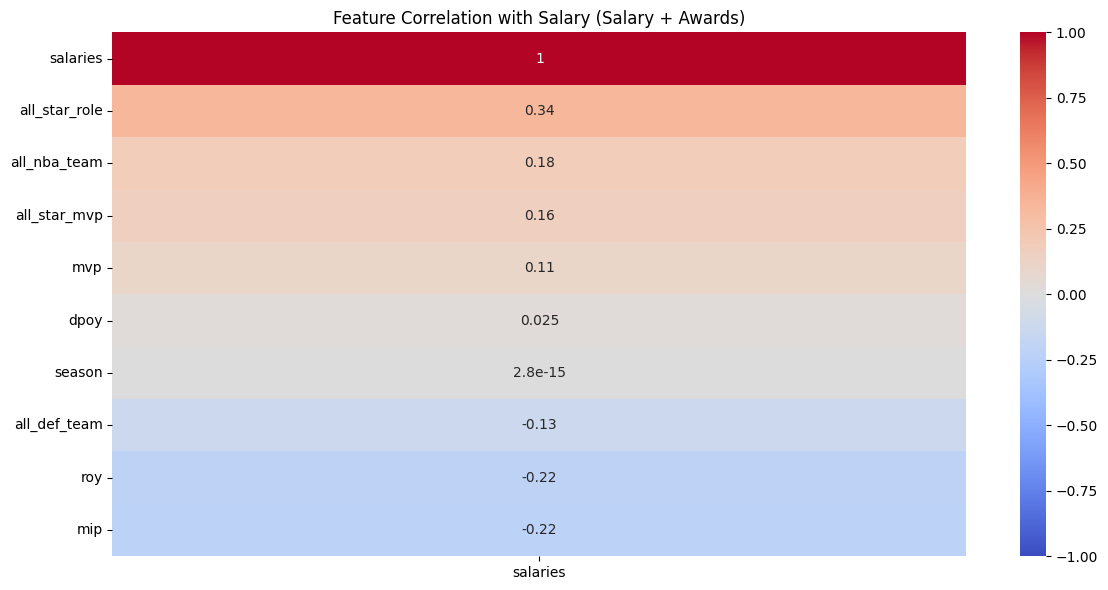

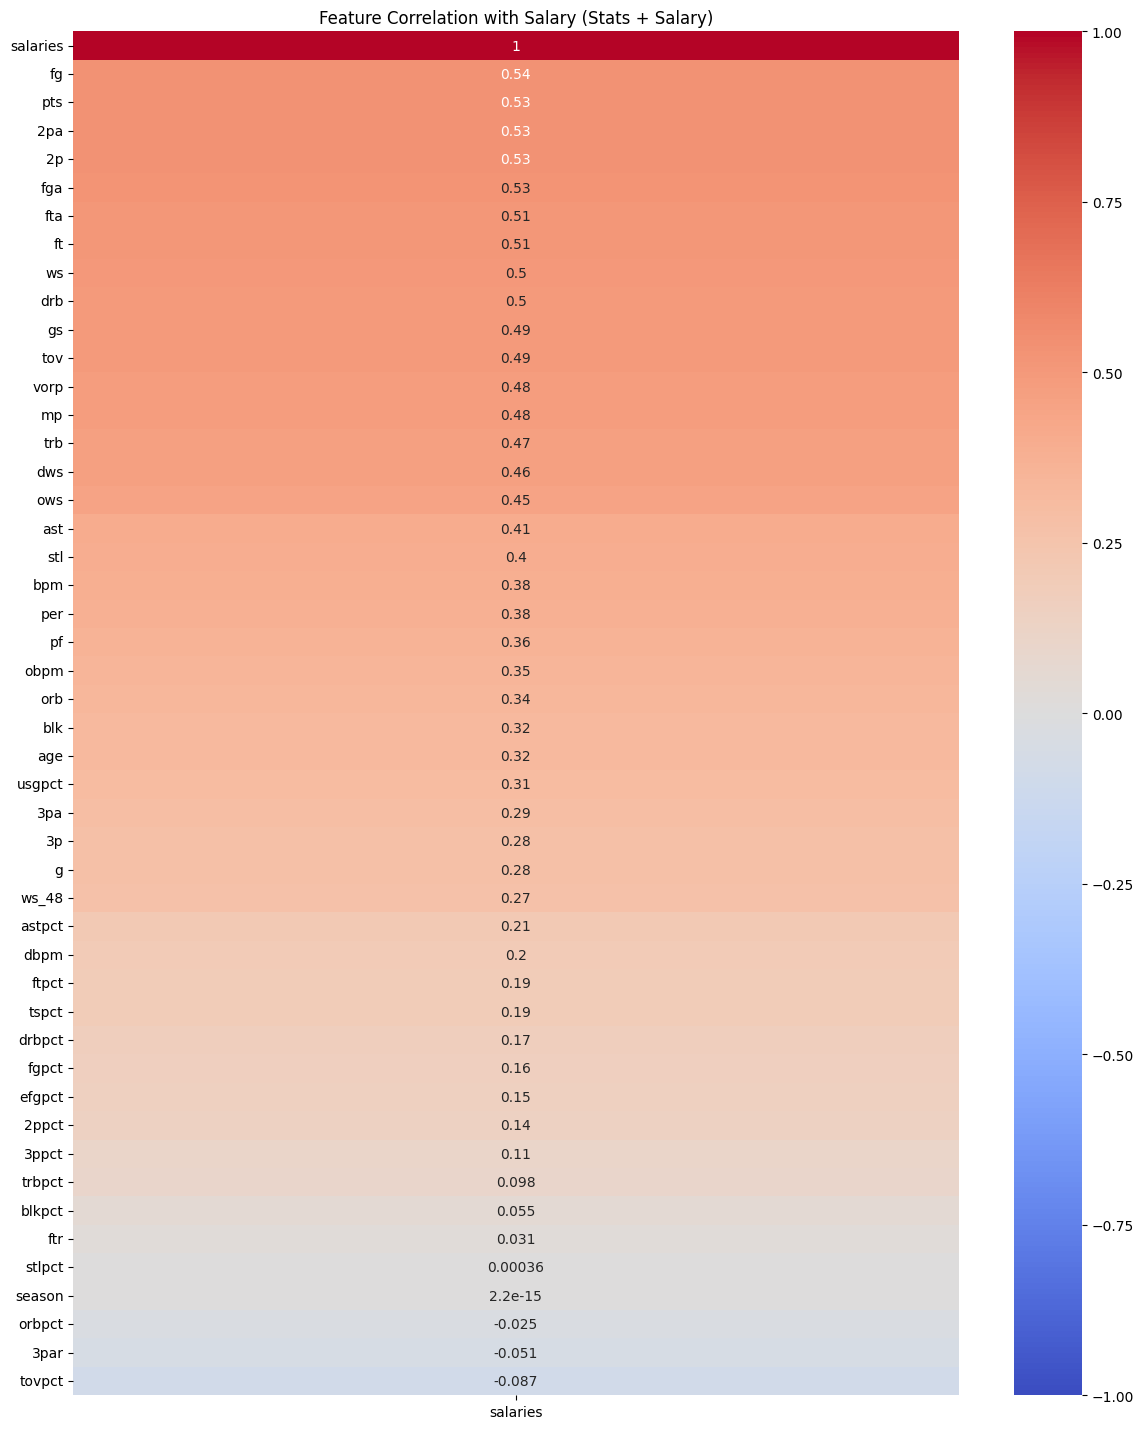

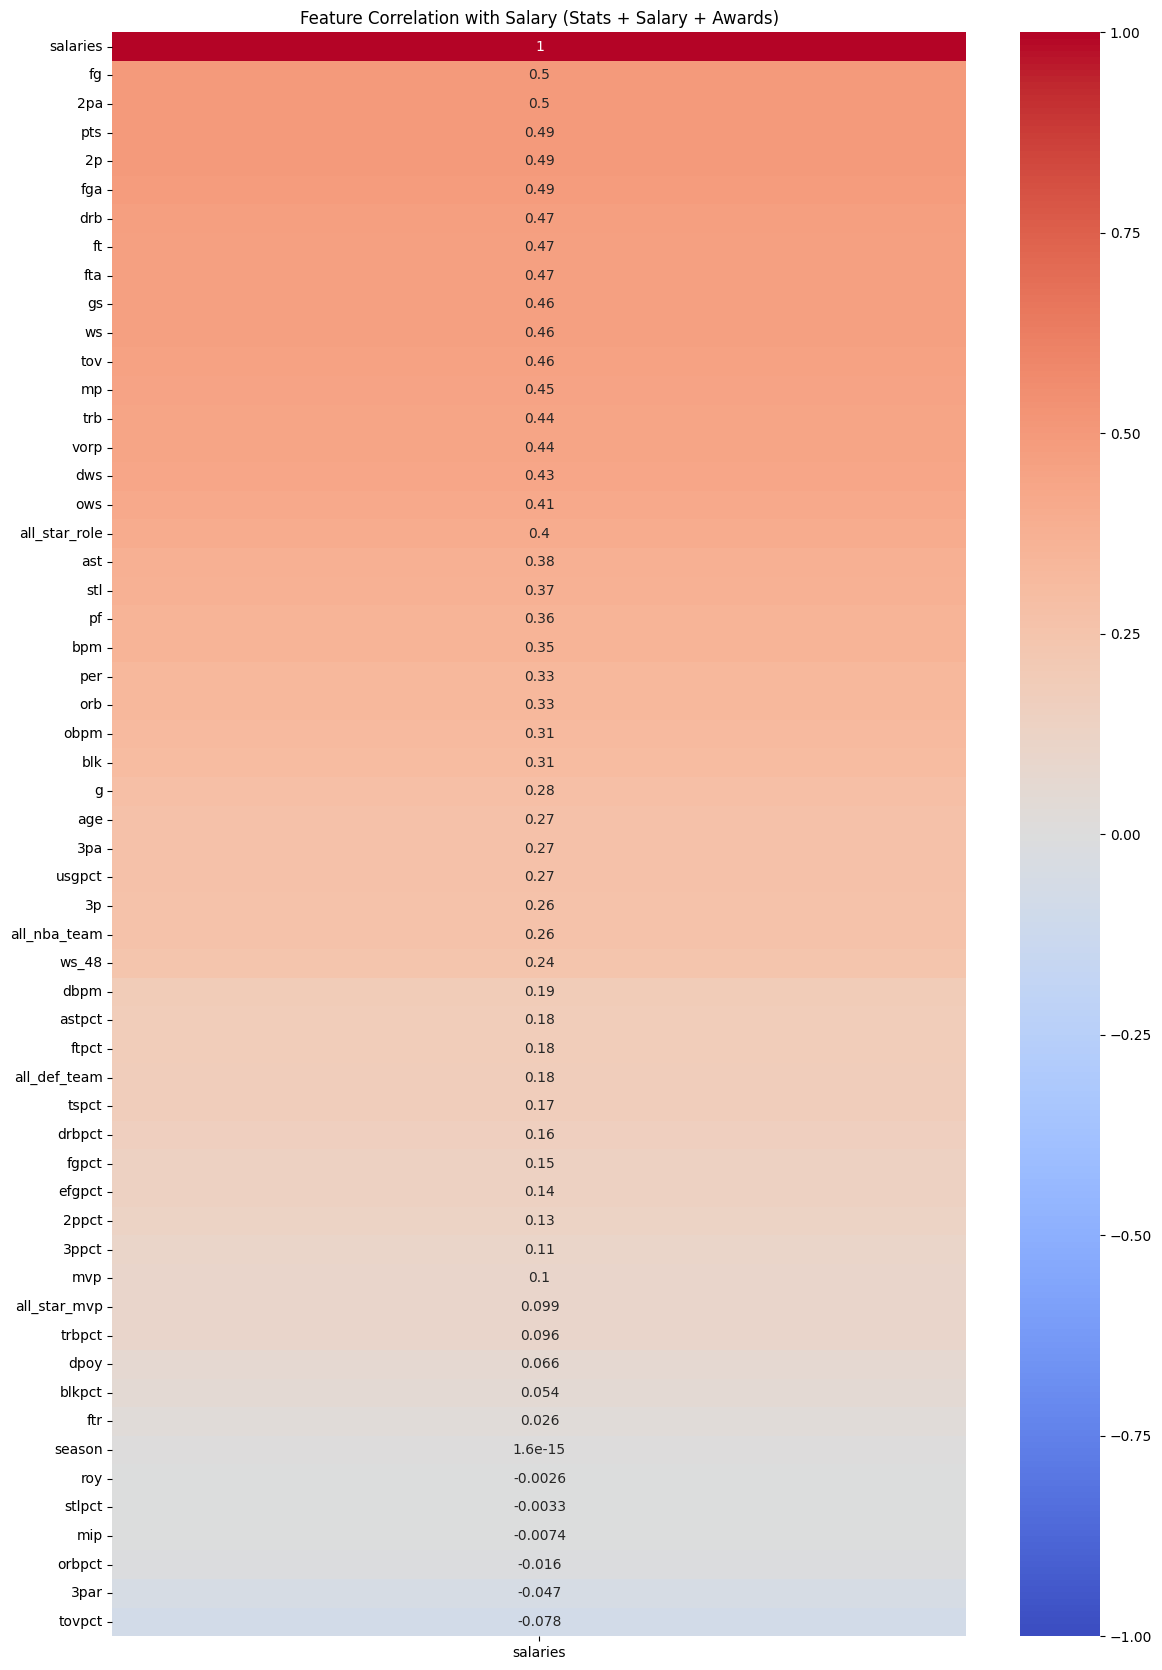

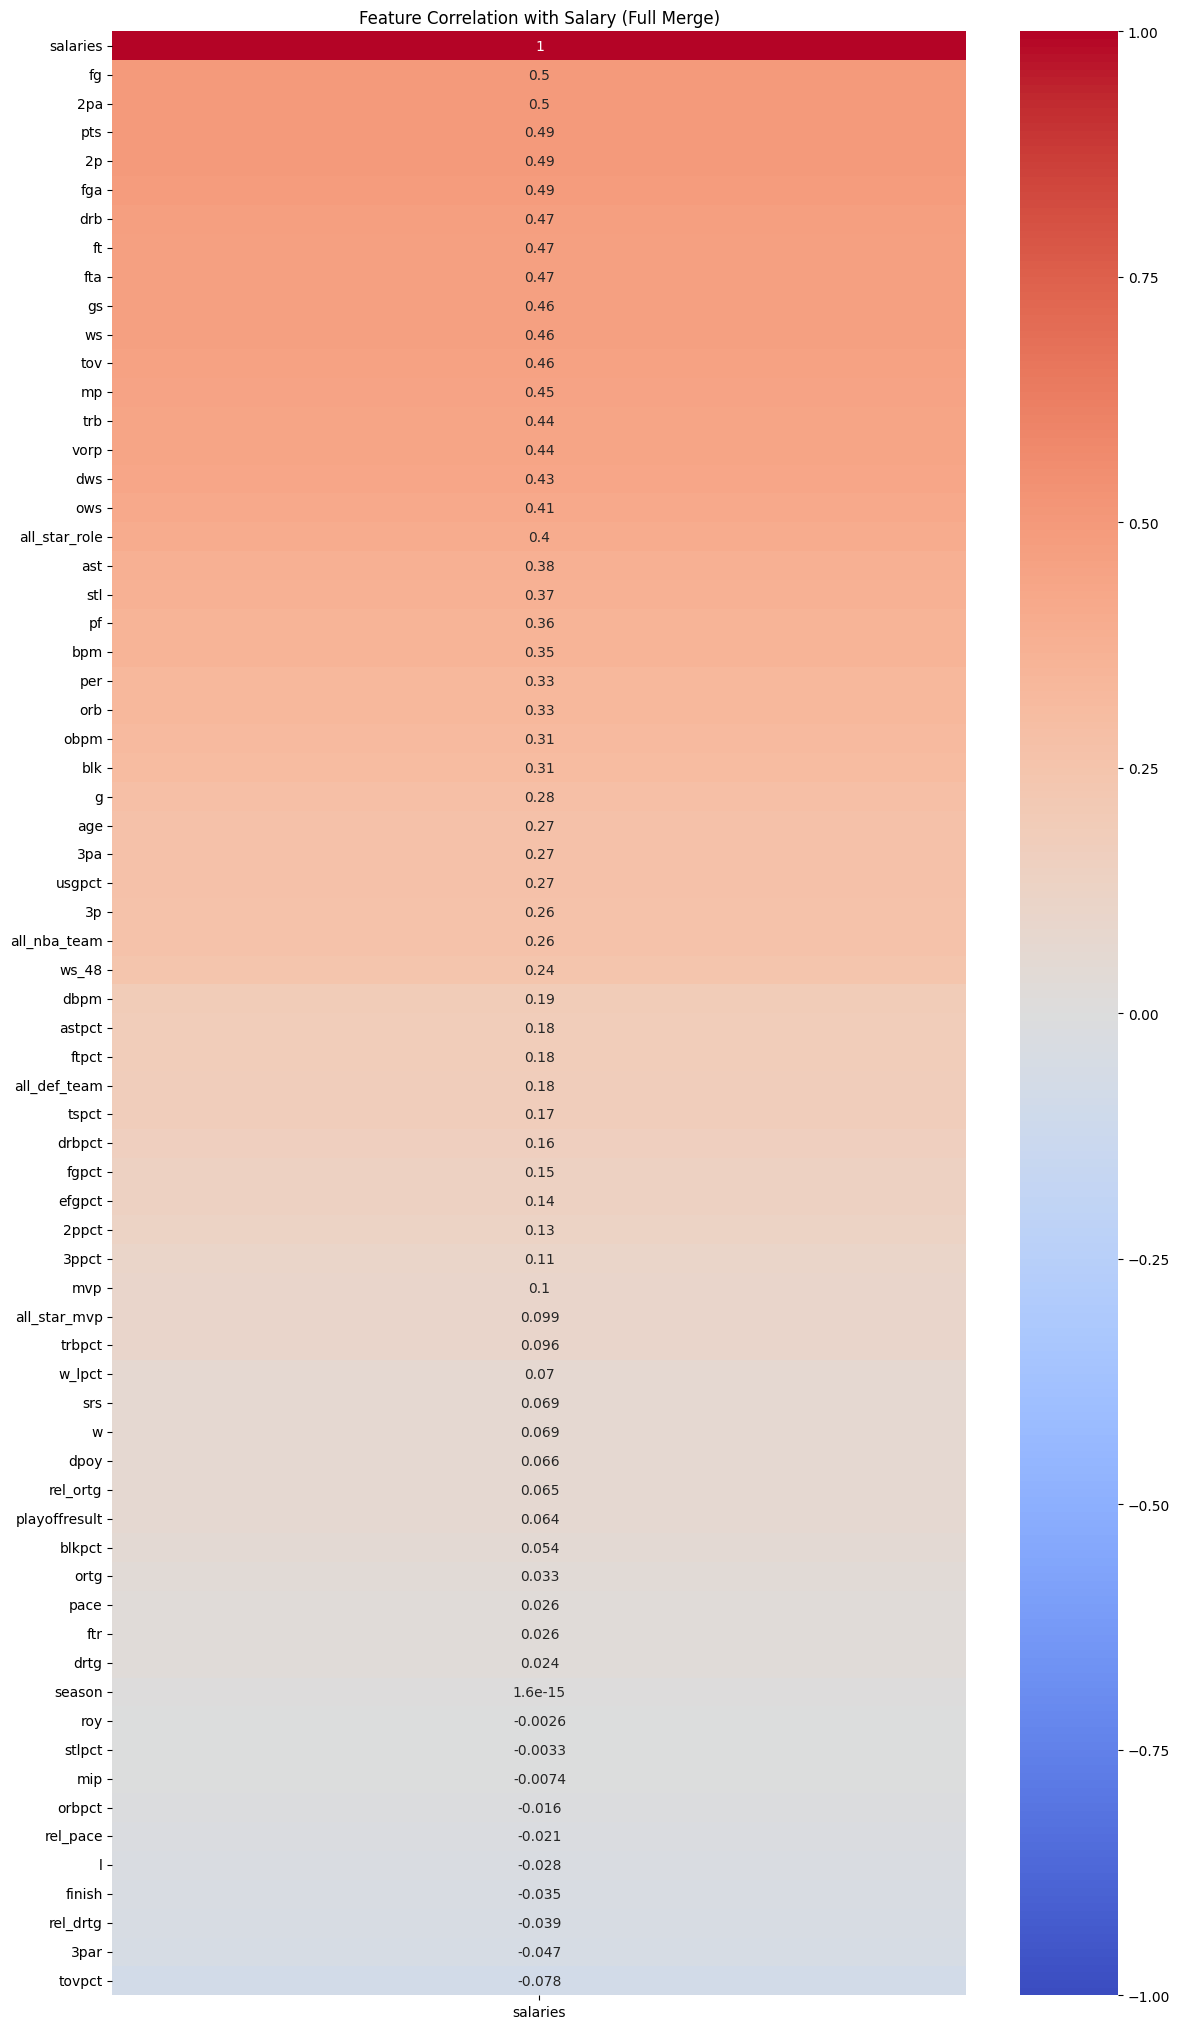

In [ ]:
## EDA correlation between features and salary

def plot_salary_correlation_heatmap(df, title_suffix=''):
    # Select numeric columns only
    numeric_cols = df.select_dtypes(include='number').columns

    # Compute correlation matrix
    corr_matrix = df[numeric_cols].corr()

    # Sort features by correlation with salary
    sorted_corr = corr_matrix['salaries'].sort_values(ascending=False)

    # Plot heatmap
    plt.figure(figsize=(12, max(6, len(sorted_corr) * 0.3)))
    sns.heatmap(sorted_corr.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f"Feature Correlation with Salary {title_suffix}")
    plt.tight_layout()
    plt.show()

# Run on all normalized datasets
plot_salary_correlation_heatmap(salary_award_norm, "(Salary + Awards)")
plot_salary_correlation_heatmap(stats_salary_norm, "(Stats + Salary)")
plot_salary_correlation_heatmap(stats_salary_award_norm, "(Stats + Salary + Awards)")
plot_salary_correlation_heatmap(stats_salary_award_team_norm, "(Full Merge)")


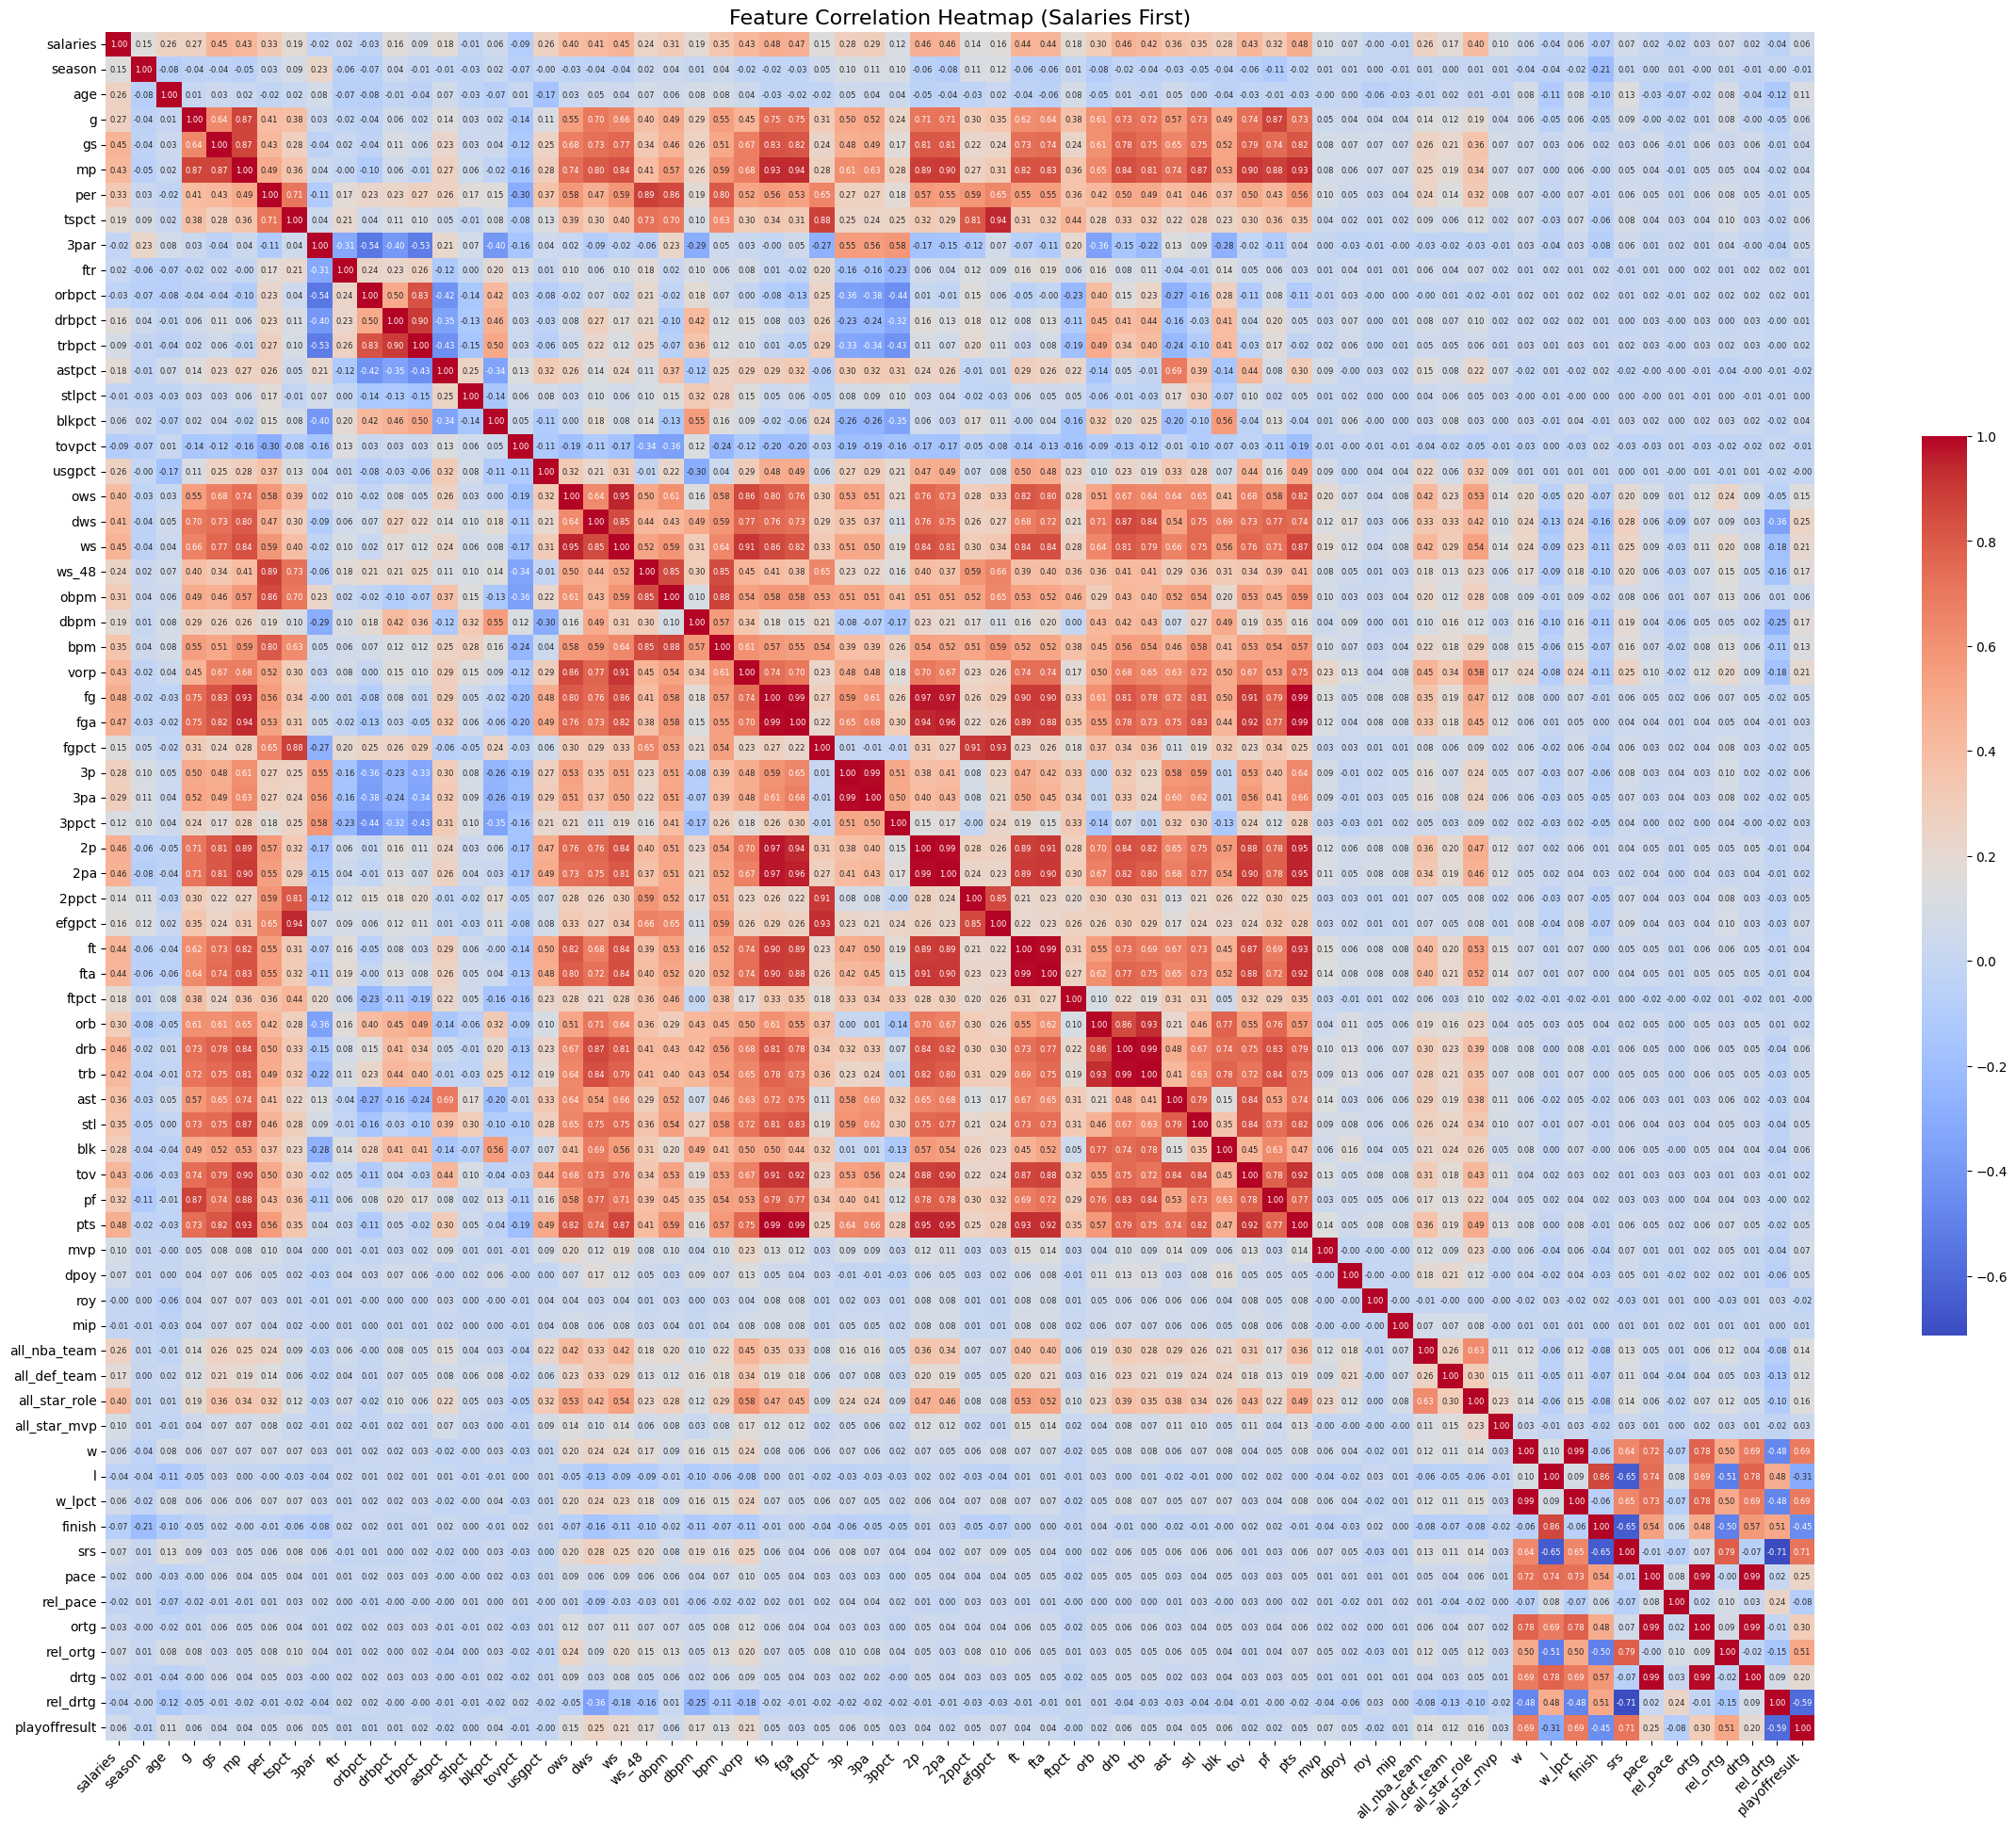

In [ ]:
## EDA Full feature correlation matrix

plt.figure(figsize=(24, 20))

# Compute correlation matrix from numeric columns
corr = stats_salary_award_team.corr(numeric_only=True)

# Move 'salaries' to the top-left corner of the matrix
cols = corr.columns.to_list()
cols.insert(0, cols.pop(cols.index('salaries')))
corr = corr.loc[cols, cols]

# Plot heatmap
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    cbar_kws={"shrink": 0.5},
    annot_kws={"size": 6}
)

plt.xticks(rotation=45, ha='right')
plt.title("Feature Correlation Heatmap (Salaries First)", fontsize=16)
plt.tight_layout()
plt.show()


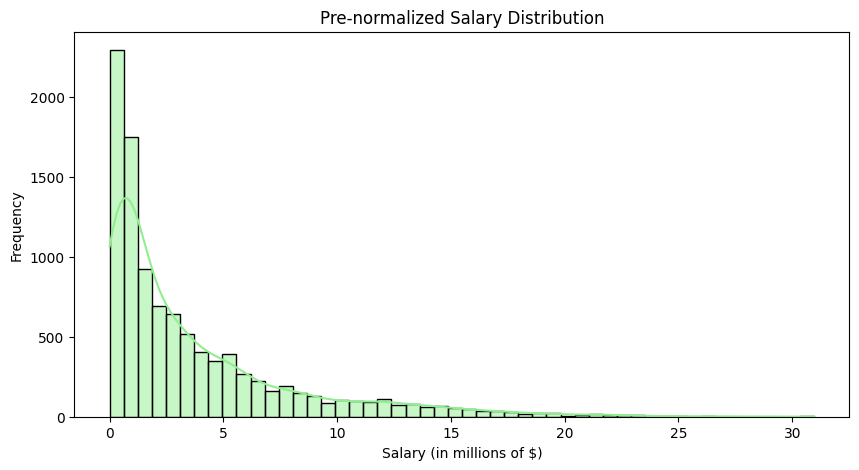

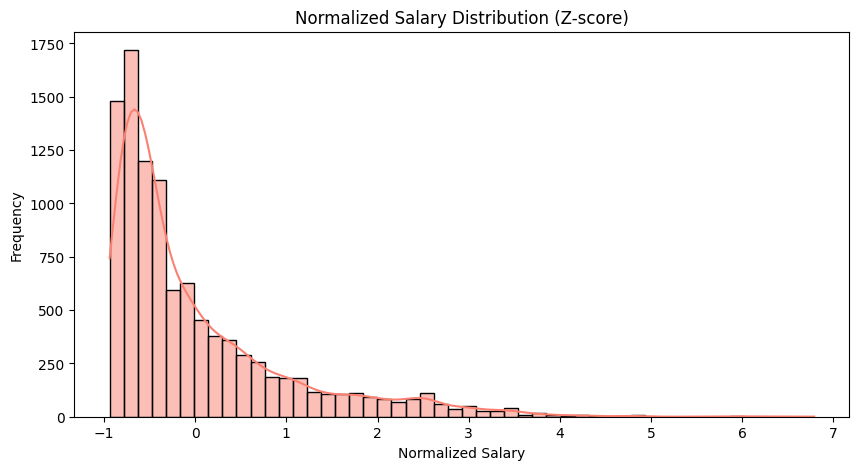

In [ ]:
## EDA feature distributions and labeled histograms

# Pre-normalized salary distribution (in millions)
plt.figure(figsize=(10, 5))
sns.histplot(stats_salary_award_team['salaries'] / 1e6, kde=True, bins=50, color='lightgreen')
plt.title("Pre-normalized Salary Distribution")
plt.xlabel("Salary (in millions of $)")
plt.ylabel("Frequency")
plt.show()

# Normalized salary distribution (Z-score)
plt.figure(figsize=(10, 5))
sns.histplot(stats_salary_award_team_norm['salaries'], kde=True, bins=50, color='salmon')
plt.title("Normalized Salary Distribution (Z-score)")
plt.xlabel("Normalized Salary")
plt.ylabel("Frequency")
plt.show()


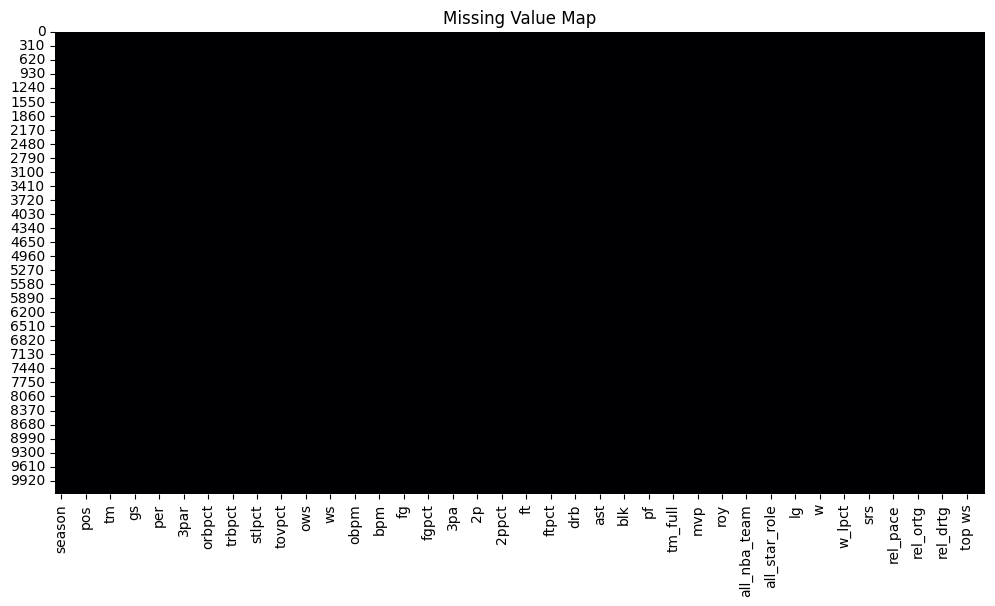

In [ ]:
## EDA Missing Values and imputation strategy

stats_salary_award_team.isnull().sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.heatmap(stats_salary_award_team.isnull(), cbar=False, cmap='magma')
plt.title("Missing Value Map")
plt.show()


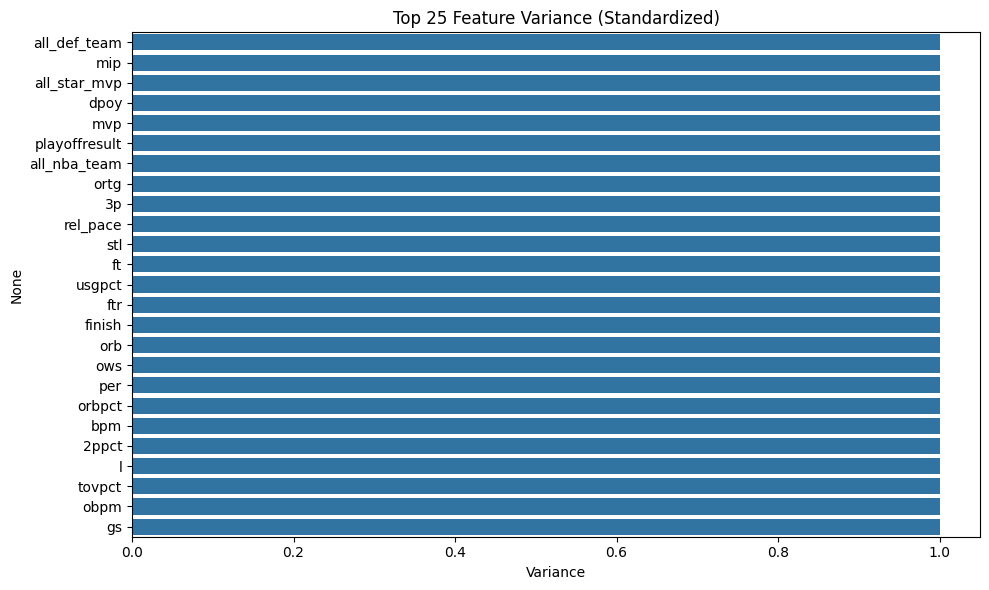

In [ ]:
##  EDA Feature variance and standardization

# Keep only numeric columns (automatically excludes strings like 'Player' or 'Team')
X_numeric = stats_salary_award_team.select_dtypes(include=['number'])

# Drop target column if it's still included
X_numeric = X_numeric.drop(columns=['salaries'], errors='ignore')

# Standardize
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

# Recalculate variance
standardized_variance = X_scaled.var().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=standardized_variance.values[:25], y=standardized_variance.index[:25])
plt.title("Top 25 Feature Variance (Standardized)")
plt.xlabel("Variance")
plt.tight_layout()
plt.show()



all_nba_team value counts:
all_nba_team
0.0    9966
2.0      80
1.0      80
3.0      78
Name: count, dtype: int64

mvp value counts:
mvp
0.0    10188
1.0       16
Name: count, dtype: int64

dpoy value counts:
dpoy
0.0    10189
1.0       15
Name: count, dtype: int64

mip value counts:
mip
0.0    10189
1.0       15
Name: count, dtype: int64

all_def_team value counts:
all_def_team
0.0    10040
2.0       83
1.0       81
Name: count, dtype: int64

all_star_role value counts:
all_star_role
0.0    9776
2.0     240
3.0     163
1.0      25
Name: count, dtype: int64

all_star_mvp value counts:
all_star_mvp
0.0    10189
1.0       15
Name: count, dtype: int64


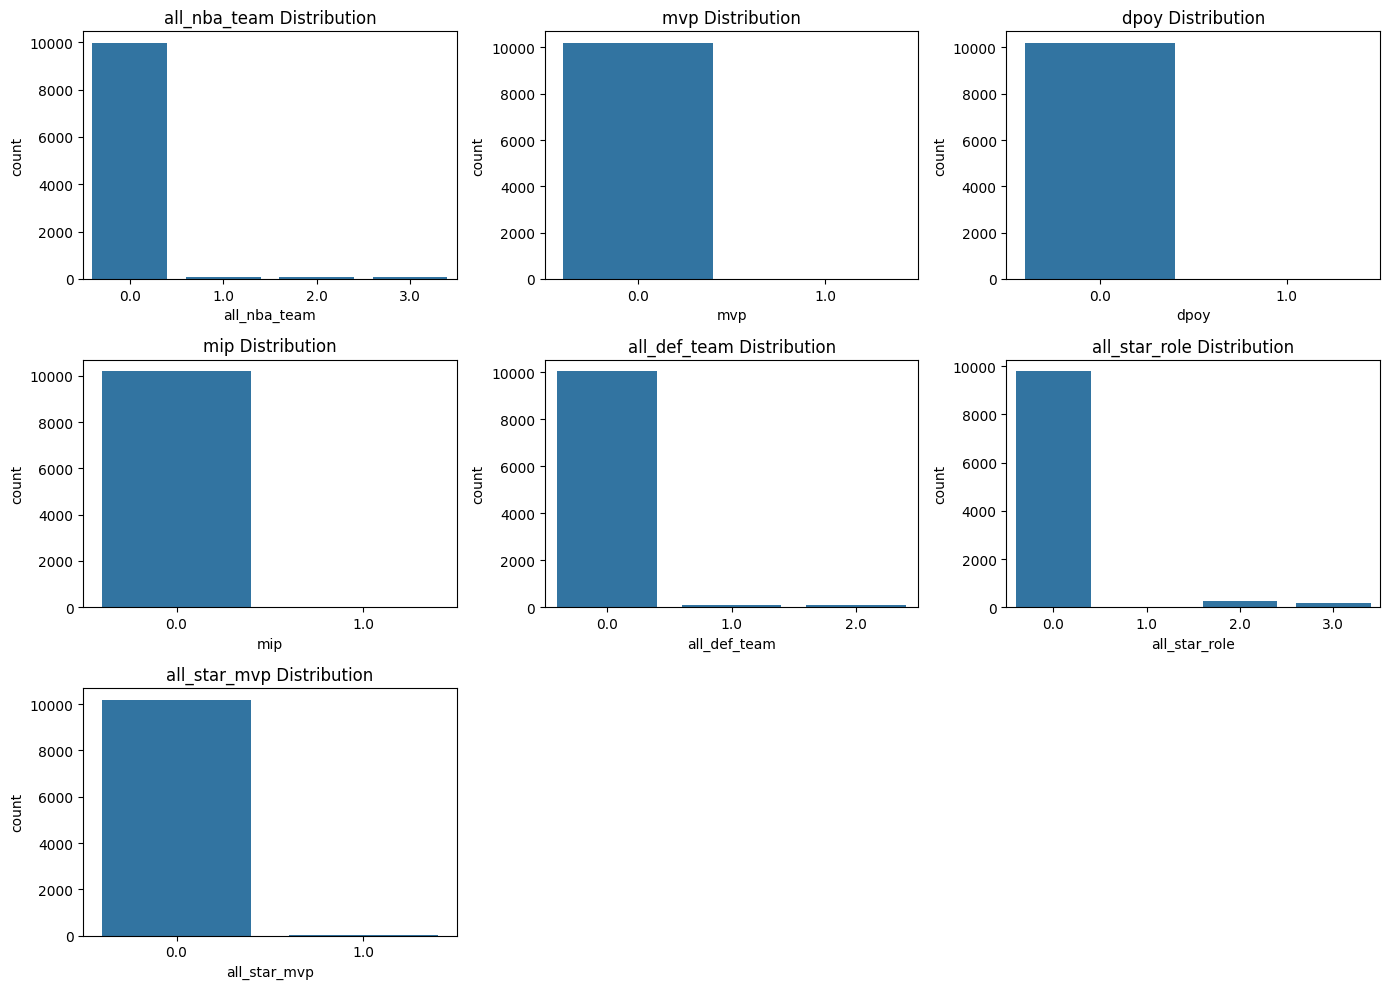

In [ ]:
## EDA Class Imbalance analysis

# Awards and categorical columns
categorical_cols = ['all_nba_team', 'mvp', 'dpoy', 'mip', 'all_def_team', 'all_star_role', 'all_star_mvp']

for col in categorical_cols:
    print(f"\n{col} value counts:")
    print(stats_salary_award_team[col].value_counts())

# Plot class distributions
plt.figure(figsize=(14, 10))
for i, col in enumerate(categorical_cols):
    plt.subplot(3, 3, i + 1)
    sns.countplot(data=stats_salary_award_team, x=col)
    plt.title(f"{col} Distribution")
    plt.tight_layout()

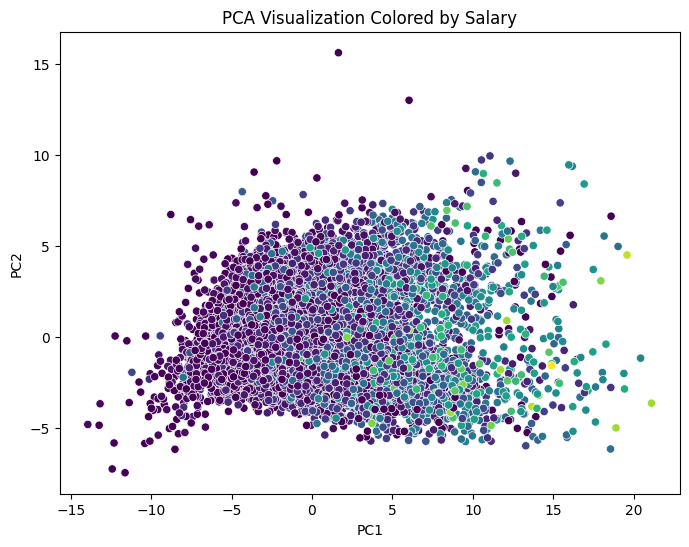

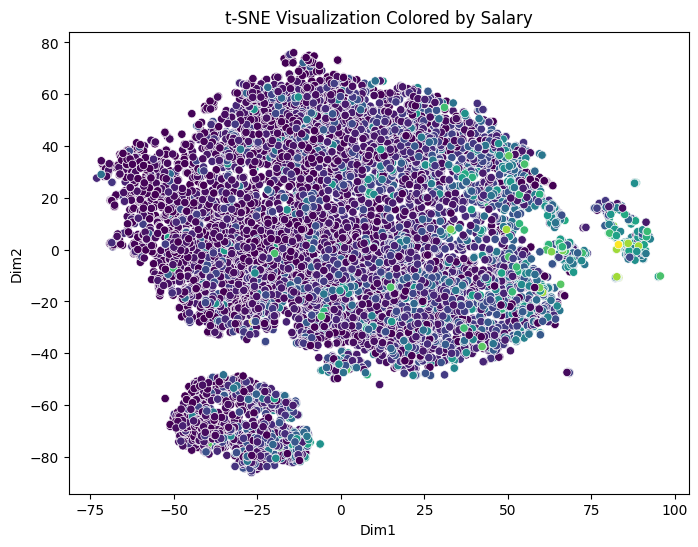

In [ ]:
## EDA TSNE or PCA visualization

# Use standardized numeric features
X = X_scaled.copy()

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Add salary back for coloring
X_pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
X_pca_df['salary'] = stats_salary_award_team['salaries'].values

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=X_pca_df, x='PC1', y='PC2', hue='salary', palette='viridis', legend=False)
plt.title("PCA Visualization Colored by Salary")
plt.show()

# Apply t-SNE (can take a bit of time)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

# Add salary back
X_tsne_df = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
X_tsne_df['salary'] = stats_salary_award_team['salaries'].values

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=X_tsne_df, x='Dim1', y='Dim2', hue='salary', palette='viridis', legend=False)
plt.title("t-SNE Visualization Colored by Salary")
plt.show()

In [ ]:
## Feature Selection

# Target variable
y = stats_salary_award_team['salaries']

# Numeric predictors only
X = stats_salary_award_team.drop(columns=['salaries'])
X = X.select_dtypes(include=['number'])

# SelectKBest using f_regression
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)

feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score_f_regression': selector.scores_
}).sort_values(by='Score_f_regression', ascending=False)

# Random Forest feature importances
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X, y)

rf_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
rf_importance = rf_importance.sort_values(ascending=False)

# Linear A: Top 12 by F-score (no VIF filtering)
features_linear_12 = feature_scores.head(12)['Feature'].tolist()
X_linear_12 = stats_salary_award_team[features_linear_12]

# Linear B: Top 12 with VIF ≤ 5
X_12_vif = sm.add_constant(X_linear_12)
vif_data_12 = pd.DataFrame()
vif_data_12["Feature"] = X_12_vif.columns
vif_data_12["VIF"] = [variance_inflation_factor(X_12_vif.values, i) for i in range(X_12_vif.shape[1])]
features_linear_vif_12 = vif_data_12[(vif_data_12["VIF"] <= 5) & (vif_data_12["Feature"] != 'const')]["Feature"].tolist()
X_linear_vif_12 = stats_salary_award_team[features_linear_vif_12]

# Linear C: Top 25 with VIF ≤ 5
features_linear_25 = feature_scores.head(25)['Feature'].tolist()
X_linear_25 = stats_salary_award_team[features_linear_25]

X_25_vif = sm.add_constant(X_linear_25)
vif_data_25 = pd.DataFrame()
vif_data_25["Feature"] = X_25_vif.columns
vif_data_25["VIF"] = [variance_inflation_factor(X_25_vif.values, i) for i in range(X_25_vif.shape[1])]
features_linear_vif_25 = vif_data_25[(vif_data_25["VIF"] <= 5) & (vif_data_25["Feature"] != 'const')]["Feature"].tolist()
X_linear_vif_25 = stats_salary_award_team[features_linear_vif_25]

# Tree-based models: Top 15 from Random Forest (no VIF filtering)
features_tree = rf_importance.head(15).index.tolist()
X_tree = stats_salary_award_team[features_tree]

# Neural network: Union of top linear and top tree features
features_nn = list(set(features_linear_12 + features_tree))
X_nn = stats_salary_award_team[features_nn]

# Print selected feature sets
print("Selected features for Linear Model (Top 12, no VIF):\n", features_linear_12)
print("\nSelected features for Linear Model (Top 12 VIF-filtered):\n", features_linear_vif_12)
print("\nSelected features for Linear Model (Top 25 VIF-filtered):\n", features_linear_vif_25)
print("\nSelected features for Tree-Based Models:\n", features_tree)
print("\nSelected features for Neural Networks:\n", features_nn)


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Selected features for Linear Model (Top 12, no VIF):
 ['fg', 'pts', 'fga', '2p', '2pa', 'drb', 'ws', 'gs', 'ft', 'fta', 'tov', 'vorp']

Selected features for Linear Model (Top 12 VIF-filtered):
 ['gs']

Selected features for Linear Model (Top 25 VIF-filtered):
 ['gs', 'all_star_role']

Selected features for Tree-Based Models:
 ['gs', 'age', 'all_star_role', 'season', 'usgpct', 'per', 'fg', 'g', 'drb', 'drbpct', 'pf', 'ftr', 'ftpct', 'tovpct', 'rel_pace']

Selected features for Neural Networks:
 ['ft', 'age', 'gs', 'rel_pace', 'tov', 'ws', 'season', 'g', 'all_star_role', 'vorp', 'ftpct', '2p', 'usgpct', 'fg', 'fga', 'ftr', 'fta', 'drb', '2pa', 'tovpct', 'pf', 'pts', 'per', 'drbpct']


In [ ]:
## Linear Model Testing

# Define feature sets to evaluate
feature_sets = {
    "Top 12 (no VIF)": X_linear_12,
    "Top 12 (VIF ≤ 5)": X_linear_vif_12,
    "Top 25 (VIF ≤ 5)": X_linear_vif_25
}

# Compare Linear Regression and SVR across feature sets
for name, X_subset in feature_sets.items():
    print(f"\n--- {name} ---")

    # Linear Regression
    linear_pipeline = make_pipeline(
        StandardScaler(),
        LinearRegression()
    )
    scores_lr = cross_val_score(
        linear_pipeline,
        X_subset,
        y,
        scoring='neg_root_mean_squared_error',
        cv=5
    )
    rmse_lr = -np.mean(scores_lr)
    print(f"Linear Regression 5-fold CV RMSE: {rmse_lr:.2f}")

    # Support Vector Regression
    svr_pipeline = make_pipeline(
        StandardScaler(),
        SVR(C=1.0, epsilon=100000)
    )
    scores_svr = cross_val_score(
        svr_pipeline,
        X_subset,
        y,
        scoring='neg_root_mean_squared_error',
        cv=5
    )
    rmse_svr = -np.mean(scores_svr)
    print(f"SVR 5-fold CV RMSE: {rmse_svr:.2f}")



--- Top 12 (no VIF) ---
Linear Regression 5-fold CV RMSE: 3837068.09
SVR 5-fold CV RMSE: 4650597.59

--- Top 12 (VIF ≤ 5) ---
Linear Regression 5-fold CV RMSE: 3982040.86
SVR 5-fold CV RMSE: 4650478.94

--- Top 25 (VIF ≤ 5) ---
Linear Regression 5-fold CV RMSE: 3817851.87
SVR 5-fold CV RMSE: 4650602.42


In [ ]:
## Tree-Based Model Testing

# Subset features and target
X_tree = stats_salary_award_team[features_tree]
y = stats_salary_award_team['salaries']

# Random Forest
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
scores_rf = cross_val_score(
    rf,
    X_tree,
    y,
    scoring='neg_root_mean_squared_error',
    cv=5
)
rmse_rf = -np.mean(scores_rf)
print(f"Random Forest 5-fold CV RMSE: {rmse_rf:.2f}")

# Decision Tree
dt = DecisionTreeRegressor(random_state=42)
scores_dt = cross_val_score(
    dt,
    X_tree,
    y,
    scoring='neg_root_mean_squared_error',
    cv=5
)
rmse_dt = -np.mean(scores_dt)
print(f"Decision Tree 5-fold CV RMSE: {rmse_dt:.2f}")

# XGBoost
xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
scores_xgb = cross_val_score(
    xgb,
    X_tree,
    y,
    scoring='neg_root_mean_squared_error',
    cv=5
)
rmse_xgb = -np.mean(scores_xgb)
print(f"XGBoost 5-fold CV RMSE: {rmse_xgb:.2f}")


Random Forest 5-fold CV RMSE: 3182091.00
Decision Tree 5-fold CV RMSE: 4434898.25
XGBoost 5-fold CV RMSE: 3131206.37


In [ ]:
## Neural Network model testing

# Subset features and target
X_nn = stats_salary_award_team[features_nn]
y = stats_salary_award_team['salaries']

# Define MLP pipeline
mlp_pipeline = make_pipeline(
    StandardScaler(),
    MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        max_iter=2000,
        random_state=42
    )
)

# Evaluate with 5-fold cross-validation
scores_mlp = cross_val_score(
    mlp_pipeline,
    X_nn,
    y,
    scoring='neg_root_mean_squared_error',
    cv=5
)

# Report RMSE
rmse_mlp = -np.mean(scores_mlp)
print(f"Neural Network (MLP) 5-fold CV RMSE: {rmse_mlp:.2f}")


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network (MLP) 5-fold CV RMSE: 3414396.22


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
## Hyperparameter Tuning

# Prepare features and target
X_tree = stats_salary_award_team[features_tree]
X_linear = stats_salary_award_team[features_linear_vif_25]
y = stats_salary_award_team['salaries']

# XGBoost tuning
xgb_base = XGBRegressor(random_state=42, n_jobs=-1)

param_dist_xgb = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

random_search_xgb = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist_xgb,
    n_iter=25,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search_xgb.fit(X_tree, y)

print("Best hyperparameters (XGBoost):", random_search_xgb.best_params_)
print(f"Best CV RMSE (XGBoost): {-random_search_xgb.best_score_:.2f}")

# Random Forest tuning
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

param_dist_rf = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2']
}

random_search_rf = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist_rf,
    n_iter=25,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search_rf.fit(X_tree, y)

print("Best hyperparameters (Random Forest):", random_search_rf.best_params_)
print(f"Best CV RMSE (Random Forest): {-random_search_rf.best_score_:.2f}")

# Ridge tuning
ridge_pipeline = make_pipeline(
    StandardScaler(),
    Ridge()
)

param_grid_ridge = {
    'ridge__alpha': [0.01, 0.1, 1, 10, 100]
}

grid_ridge = GridSearchCV(
    ridge_pipeline,
    param_grid=param_grid_ridge,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_ridge.fit(X_linear, y)

print("Best alpha (Ridge):", grid_ridge.best_params_)
print(f"Best CV RMSE (Ridge): {-grid_ridge.best_score_:.2f}")

# Lasso tuning
lasso_pipeline = make_pipeline(
    StandardScaler(),
    Lasso(max_iter=10000)
)

param_grid_lasso = {
    'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1]
}

grid_lasso = GridSearchCV(
    lasso_pipeline,
    param_grid=param_grid_lasso,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_lasso.fit(X_linear, y)

print("Best alpha (Lasso):", grid_lasso.best_params_)
print(f"Best CV RMSE (Lasso): {-grid_lasso.best_score_:.2f}")


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best hyperparameters (XGBoost): {'colsample_bytree': np.float64(0.7599443886861021), 'learning_rate': np.float64(0.023999698964084628), 'max_depth': 6, 'n_estimators': 370, 'subsample': np.float64(0.7824279936868144)}
Best CV RMSE (XGBoost): 3103442.59
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best hyperparameters (Random Forest): {'max_depth': 29, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 364}
Best CV RMSE (Random Forest): 3184267.10
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best alpha (Ridge): {'ridge__alpha': 100}
Best CV RMSE (Ridge): 3817238.94
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best alpha (Lasso): {'lasso__alpha': 1}
Best CV RMSE (Lasso): 3817851.82


In [ ]:
## Final Model Training

# Prepare final feature sets
X_final_tree = stats_salary_award_team[features_tree]
X_final_linear = stats_salary_award_team[features_linear_vif_25]
y_final = stats_salary_award_team['salaries']

# Final XGBoost model (best params from tuning)
xgb_final = XGBRegressor(
    colsample_bytree=0.76,
    learning_rate=0.024,
    max_depth=6,
    n_estimators=370,
    subsample=0.78,
    random_state=42,
    n_jobs=-1
)
xgb_final.fit(X_final_tree, y_final)

# Final Random Forest model (best params from tuning)
rf_final = RandomForestRegressor(
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=7,
    n_estimators=274,
    random_state=42,
    n_jobs=-1
)
rf_final.fit(X_final_tree, y_final)

# Final Ridge model
ridge_final = make_pipeline(
    StandardScaler(),
    Ridge(alpha=grid_ridge.best_params_['ridge__alpha'])
)
ridge_final.fit(X_final_linear, y_final)

# Final Lasso model
lasso_final = make_pipeline(
    StandardScaler(),
    Lasso(alpha=grid_lasso.best_params_['lasso__alpha'], max_iter=10000)
)
lasso_final.fit(X_final_linear, y_final)

print("Final models trained.")


Final models trained.


XGBoost RMSE: 2124192.01 | MAE: 1478396.10 | R²: 0.767
Random Forest RMSE: 1754987.40 | MAE: 1167971.45 | R²: 0.841
Ridge Regression RMSE: 3772637.92 | MAE: 2709469.92 | R²: 0.265
Lasso Regression RMSE: 3772602.21 | MAE: 2707786.22 | R²: 0.265


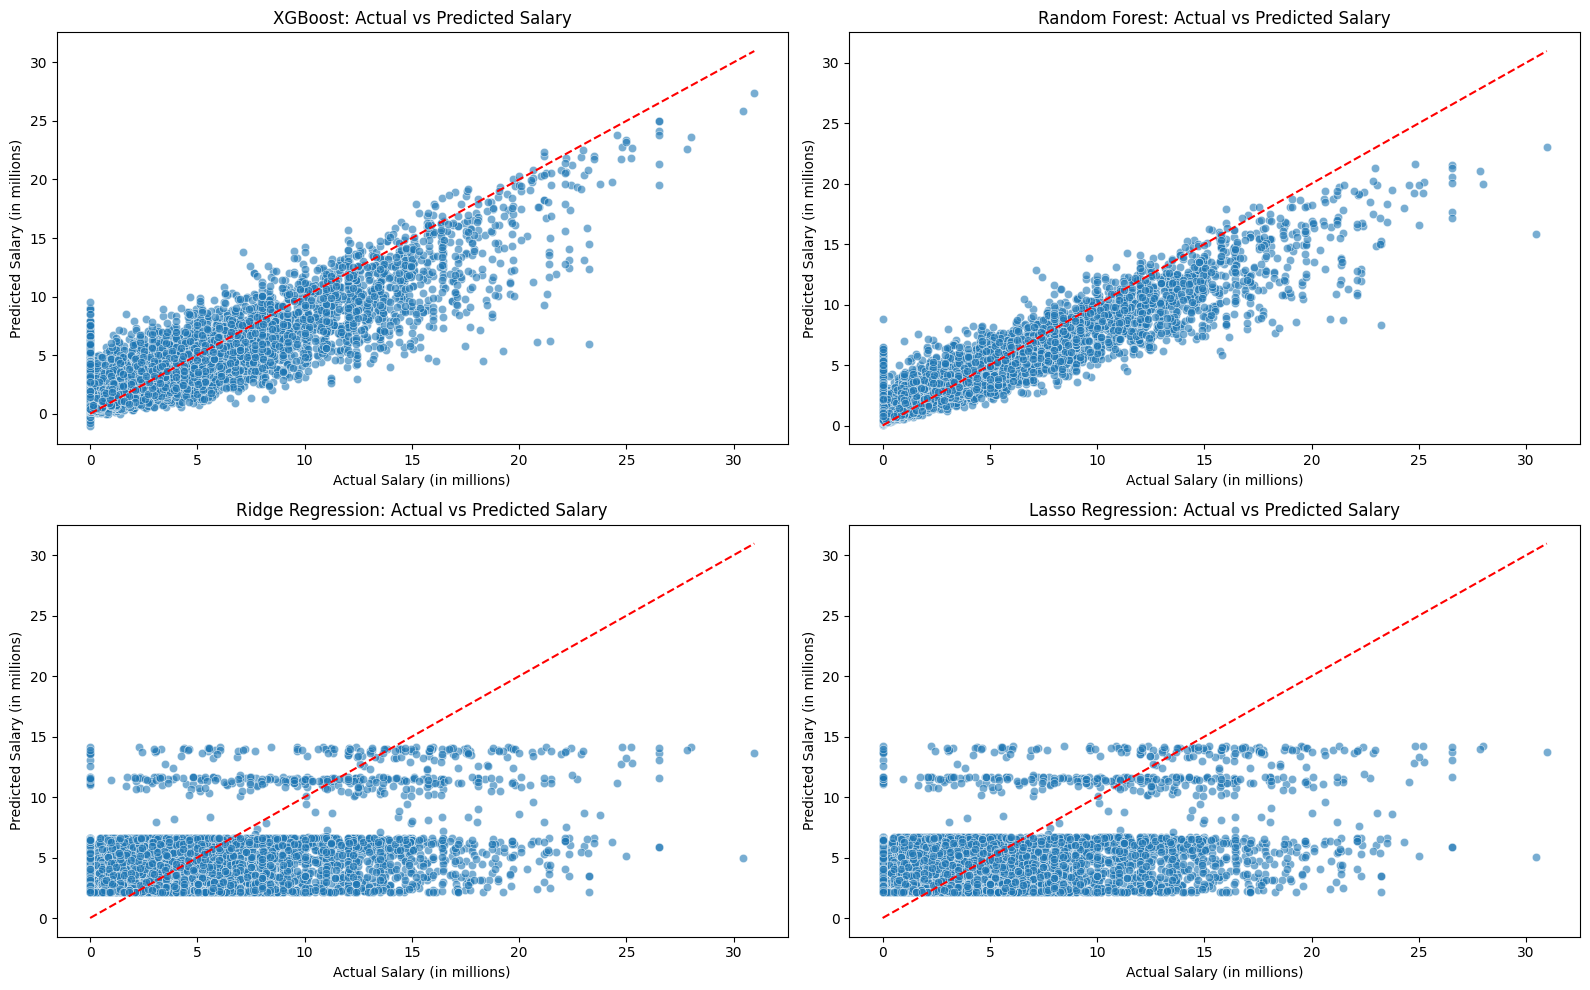

In [ ]:
## Final Model Evaluation and Visualization

# Predict
y_pred_xgb = xgb_final.predict(X_final_tree)
y_pred_rf = rf_final.predict(X_final_tree)
y_pred_ridge = ridge_final.predict(X_final_linear)
y_pred_lasso = lasso_final.predict(X_final_linear)

# Calculate RMSE
rmse_xgb = np.sqrt(mean_squared_error(y_final, y_pred_xgb))
rmse_rf = np.sqrt(mean_squared_error(y_final, y_pred_rf))
rmse_ridge = np.sqrt(mean_squared_error(y_final, y_pred_ridge))
rmse_lasso = np.sqrt(mean_squared_error(y_final, y_pred_lasso))

# R² score
r2_xgb = r2_score(y_final, y_pred_xgb)
r2_rf = r2_score(y_final, y_pred_rf)
r2_ridge = r2_score(y_final, y_pred_ridge)
r2_lasso = r2_score(y_final, y_pred_lasso)

# MAE
mae_xgb = mean_absolute_error(y_final, y_pred_xgb)
mae_rf = mean_absolute_error(y_final, y_pred_rf)
mae_ridge = mean_absolute_error(y_final, y_pred_ridge)
mae_lasso = mean_absolute_error(y_final, y_pred_lasso)

# Print performance
print(f"XGBoost RMSE: {rmse_xgb:.2f} | MAE: {mae_xgb:.2f} | R²: {r2_xgb:.3f}")
print(f"Random Forest RMSE: {rmse_rf:.2f} | MAE: {mae_rf:.2f} | R²: {r2_rf:.3f}")
print(f"Ridge Regression RMSE: {rmse_ridge:.2f} | MAE: {mae_ridge:.2f} | R²: {r2_ridge:.3f}")
print(f"Lasso Regression RMSE: {rmse_lasso:.2f} | MAE: {mae_lasso:.2f} | R²: {r2_lasso:.3f}")

# Plot actual vs predicted salaries (in millions)
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
sns.scatterplot(x=y_final / 1e6, y=y_pred_xgb / 1e6, alpha=0.6)
plt.title("XGBoost: Actual vs Predicted Salary")
plt.xlabel("Actual Salary (in millions)")
plt.ylabel("Predicted Salary (in millions)")
plt.plot([y_final.min()/1e6, y_final.max()/1e6], [y_final.min()/1e6, y_final.max()/1e6], 'r--')

plt.subplot(2, 2, 2)
sns.scatterplot(x=y_final / 1e6, y=y_pred_rf / 1e6, alpha=0.6)
plt.title("Random Forest: Actual vs Predicted Salary")
plt.xlabel("Actual Salary (in millions)")
plt.ylabel("Predicted Salary (in millions)")
plt.plot([y_final.min()/1e6, y_final.max()/1e6], [y_final.min()/1e6, y_final.max()/1e6], 'r--')

plt.subplot(2, 2, 3)
sns.scatterplot(x=y_final / 1e6, y=y_pred_ridge / 1e6, alpha=0.6)
plt.title("Ridge Regression: Actual vs Predicted Salary")
plt.xlabel("Actual Salary (in millions)")
plt.ylabel("Predicted Salary (in millions)")
plt.plot([y_final.min()/1e6, y_final.max()/1e6], [y_final.min()/1e6, y_final.max()/1e6], 'r--')

plt.subplot(2, 2, 4)
sns.scatterplot(x=y_final / 1e6, y=y_pred_lasso / 1e6, alpha=0.6)
plt.title("Lasso Regression: Actual vs Predicted Salary")
plt.xlabel("Actual Salary (in millions)")
plt.ylabel("Predicted Salary (in millions)")
plt.plot([y_final.min()/1e6, y_final.max()/1e6], [y_final.min()/1e6, y_final.max()/1e6], 'r--')

plt.tight_layout()
plt.show()
